# CIS6800: Project 2: YOLO
### Due:
* Part A - Sept. 18 at 11:59 p.m.
* Part B - Sept. 25 at 11:59 p.m.

### Instructions:
* Part A consists of parts 1-4 and is due on September 18th at 11:59 p.m. EDT.
* Part B consists of parts 5-8 and is due on September 25th at 11:59 p.m. EDT.
* As the autograder uses the definitions for functions and classes you submit,
please do not modify the name of any function or class provided.
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.

## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you donâ€™t need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} = 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} + 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} + 
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} + 
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} + 
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Code

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch_lightning &> /dev/null

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [ ]:
# Use this function to import the provided data files
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

# images = load_data('/content/drive/MyDrive/yolo_maybe/data/images.npz')
# raw_labels = load_data('/content/drive/MyDrive/yolo_maybe/data/labels.npz')


In [ ]:
# raw_labels.shape, images.shape

((9900,), (9900, 128, 128, 3))

In [ ]:
# This function should compute the 8X8X8 label from the raw labels for the corresponding image.

def process_labels(raw_labels):
    '''
    Process series of raw_labels 
    '''
    labels = process_single_label(raw_labels[0]).unsqueeze(0)
    for raw_label in raw_labels[1:]:
      labels = torch.vstack((labels,process_single_label(raw_label).unsqueeze(0)))
    return labels

def process_single_label(raw_labels):
    '''
    raw_labels details:  class, x1,y1,x2,y2

    Patches of 16x16 :
    0-15, 16-31, 32-47, 48-63, 64-79, 80-95, 96-111, 112-127
    '''

    labels = torch.zeros((8,8,8))
    index = torch.tensor([i*16 for i in range(1,9)])

    for p in raw_labels:
      # print(p)
      x1, y1, x2, y2 = p[1:5]
      center = (x1 + ((x2-x1)/2)), (y1 + ((y2-y1)/2))

      i = torch.where(index - center[0]>0)[0][0]
      j = torch.where(index - center[1]>0)[0][0]

      labels[0][i][j] = 1 #P(object)
      # x,y,w,h
      labels[1][i][j] = (center[0]%16)/16 #x coord
      labels[2][i][j] = (center[1]%16)/16 #y coord
      labels[3][i][j] = (x2-x1)/128 #width
      labels[4][i][j] = (y2-y1)/128 #height 

      # P(Class) - get index of class 
      labels[int(p[0] + 5)][i][j] = 1
      for c in set({0,1,2}).difference(set({int(p[0])})):
        labels[int(c + 5)][i][j] = 0
    return labels

In [ ]:
# labels = process_labels(raw_labels[8:9])
# labels

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0312, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.9375, 0.0000, 0.6562, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.7812, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.6250, 0.0000, 0.0000, 0.0000, 0.0000],
          

In [ ]:
def get_cord(x,y,w,h,i,j,img_dim=128):
  x1 = (x*16)+(i*16) - (w*img_dim/2)
  y1 = (y*16)+(j*16) - (h*img_dim/2)
  x2 = (w*img_dim) + x1
  y2 = (h*img_dim) + y1
  return x1,y1,x2,y2

In [ ]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128):
    i, j = torch.where(labels[0]==1)
    raw_labels = []
    for p in range(len(i)):
      c = [c for c in [5,6,7] if labels[c][i[p]][j[p]]==1][0]
      x,y,w,h = labels[1][i[p]][j[p]],labels[2][i[p]][j[p]],labels[3][i[p]][j[p]],labels[4][i[p]][j[p]]
      x1,y1,x2,y2 = get_cord(x,y,w,h,i[p],j[p])

      raw_labels.append([c-5, x1.item(),y1.item(),x2.item(),y2.item()])
    return np.array(raw_labels)

In [ ]:
# reconstruct_raw_labels(labels[0])

array([[  2.,   0.,  46.,  33.,  80.],
       [  1.,  45.,  24.,  49.,  35.],
       [  0.,  41.,  48.,  44.,  58.],
       [  2.,  49.,  48.,  72.,  59.],
       [  0.,  68.,  42.,  80.,  64.],
       [  2.,  90.,  48., 113.,  62.],
       [  2., 108.,  42., 128.,  81.]])

In [ ]:
# raw_labels[8:9]

array([array([[  2.,  90.,  48., 113.,  62.],
              [  2.,   0.,  46.,  33.,  80.],
              [  2., 108.,  42., 128.,  81.],
              [  0.,  68.,  42.,  80.,  64.],
              [  1.,  45.,  24.,  49.,  35.],
              [  0.,  43.,  47.,  47.,  58.],
              [  0.,  41.,  48.,  44.,  58.],
              [  2.,  49.,  48.,  72.,  59.]])], dtype=object)

In [ ]:
def yolo_loss(output, target):
    lambda_coord = 5
    lambda_no_obj = 0.5
    grid_size = 8

    # Cordinate loss
    xy_loss = torch.sum(torch.sum((pow(target[:,1] - output[:,1],2) + pow(target[:,2] - output[:,2],2))*target[:,0],dim=(1,2)))
    wh_loss = torch.sum(torch.sum((pow(torch.sqrt(target[:,3])-torch.sqrt(output[:,3]),2) + pow(torch.sqrt(target[:,4]) - torch.sqrt(output[:,4]),2))*target[:,0],dim=(1,2)))
    # print("loc")
    # print((lambda_coord*xy_loss) , (lambda_coord*wh_loss))
    # print((lambda_coord*xy_loss) + (lambda_coord*wh_loss))

    # Confidence score loss
    x_low = torch.maximum(target[:,1] - grid_size * target[:,3]/2,output[:,1] - grid_size * output[:,3]/2)
    x_top = torch.minimum(target[:,1] + grid_size * target[:,3]/2,output[:,1] + grid_size * output[:,3]/2)
    y_low = torch.maximum(target[:,2] - grid_size * target[:,4]/2,output[:,2] - grid_size * output[:,4]/2)
    y_top = torch.minimum(target[:,2] + grid_size * target[:,4]/2,output[:,2] + grid_size * output[:,4]/2)

    intersection = torch.maximum((x_top - x_low),torch.zeros_like(x_top)) * torch.maximum((y_top - y_low),torch.zeros_like(y_top))
    union = target[:,3] * target[:,4] * grid_size**2 + output[:,3] * output[:,4] * grid_size**2 - intersection + 1e-6
    ious = intersection / union

    iou_loss_obj = torch.sum(target[:,0] * pow((target[:,0]*ious - output[:,0]),2))
    iou_loss_no_obj = torch.sum((1-target[:,0]) * pow((target[:,0]*ious - output[:,0]),2))

    # print("conf")
    # print(iou_loss_obj,(lambda_no_obj*iou_loss_no_obj))
    # print(iou_loss_obj+(lambda_no_obj*iou_loss_no_obj))

    # Class prediction loss
    class_loss = torch.sum(torch.sum((pow(target[:,5:] - output[:,5:],2).sum(axis=1))*target[:,0],dim=(1,2)))
    # print("class\n",class_loss)

    # Total Loss
    loss = (lambda_coord*xy_loss) + (lambda_coord*wh_loss) + iou_loss_obj + (lambda_no_obj*iou_loss_no_obj) + class_loss
    # print(xy_loss,wh_loss,iou_loss_obj,iou_loss_no_obj,class_loss,torch.mean(loss))

    # return loss
    return loss, lambda_coord*(xy_loss+wh_loss) , iou_loss_obj+lambda_no_obj*iou_loss_no_obj , class_loss

In [ ]:
# target = labels[0].unsqueeze(0)
# output = torch.where(target>0,target+0.005,0)
# yolo_loss(target,output)

In [ ]:
def reconstruct_raw_labels_conf(labels, img_dim=128):
    i, j = torch.where(labels[0]>0)
    raw_labels = []
    for p in range(len(i)):
      c = np.argmax(labels[5:],axis=0)[i[p]][j[p]]
      x,y,w,h = labels[1][i[p]][j[p]],labels[2][i[p]][j[p]],labels[3][i[p]][j[p]],labels[4][i[p]][j[p]]
      x1,y1,x2,y2 = get_cord(x,y,w,h,i[p],j[p])

      raw_labels.append([c,labels[0][i[p]][j[p]], x1.item(),y1.item(),x2.item(),y2.item()])
    return np.array(raw_labels)

In [ ]:
train_loss_list = {'loss':[], 'localisation_loss':[],'confidence_loss':[],'class_loss':[]}
val_loss_list = {'loss':[], 'localisation_loss':[],'confidence_loss':[],'class_loss':[]}

train_results = []
val_results = []

from torch.nn.modules import activation
class YOLO(pl.LightningModule):

  #  https://drive.google.com/uc?id=12F5O60Hd-68xk5qEYHpk7YEWn5U2K_p-&export=download
  #   model_url = 'https://drive.google.com/file/d/12F5O60Hd-68xk5qEYHpk7YEWn5U2K_p-/view?usp=sharing'
    model_url = 'https://drive.google.com/uc?id=12F5O60Hd-68xk5qEYHpk7YEWn5U2K_p-&export=download&confirm=t&uuid=a1dd0549-6f74-4b26-8111-de717dfa082c'

    def __init__(self):
        super().__init__()
        # conv
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1)
        # transpose conv
        self.conv7 = nn.ConvTranspose2d(in_channels=1024,out_channels=256,kernel_size=4,stride=2,padding=1)
        self.conv8 = nn.ConvTranspose2d(in_channels=256,out_channels=64,kernel_size=4,stride=2,padding=1)
        # final conv
        self.conv9 = nn.Conv2d(in_channels=64, out_channels=8, kernel_size=3, stride=1, padding=1)
        # batch norm
        self.batch1 = nn.BatchNorm2d(num_features=32)
        self.batch2 = nn.BatchNorm2d(num_features=64)
        self.batch3 = nn.BatchNorm2d(num_features=128)
        self.batch4 = nn.BatchNorm2d(num_features=256)
        self.batch5 = nn.BatchNorm2d(num_features=512)
        self.batch6 = nn.BatchNorm2d(num_features=1024)
        self.batch7 = nn.BatchNorm2d(num_features=256)
        self.batch8 = nn.BatchNorm2d(num_features=64)
        # activation
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.batch1(self.conv1(x)))
        x = self.relu(self.batch2(self.conv2(x)))
        x = self.relu(self.batch3(self.conv3(x)))
        x = self.relu(self.batch4(self.conv4(x)))
        x = self.relu(self.batch5(self.conv5(x)))
        x = self.relu(self.batch6(self.conv6(x)))
        x = self.relu(self.batch7(self.conv7(x)))
        x = self.relu(self.batch8(self.conv8(x)))
        x = self.conv9(x)
        return torch.sigmoid(x)

    def training_step(self, batch, batch_idx):
        data, label = batch
        pred = self(data)
        loss, localisation_loss , confidence_loss , class_loss = yolo_loss(pred, label)
        loss = loss.mean()
        # acc = (pred.argmax(1) == label).float().mean()
        # self.log("train_acc", acc, prog_bar=True)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss":loss, 
                "localisation_loss":localisation_loss.mean(),
                "confidence_loss":confidence_loss.mean(),
                "class_loss":class_loss.mean(),
                "prediction":pred,
                "label":label}

    def training_epoch_end(self, training_step_outputs):
      temp1, temp2, temp3, temp4 = [],[],[],[]
      preds, labels = [], []

      step_number = []
      
      for out in training_step_outputs:
        # print("epoch end",out)
        temp1.append(out['loss'].item())
        temp2.append(out['localisation_loss'].item())
        temp3.append(out['confidence_loss'].item())
        temp4.append(out['class_loss'].item())
        preds.append(out['prediction'])
        labels.append(out['label'])
        step_number.append(out['prediction'].shape[0])

      train_loss_list['loss'].append(torch.sum(torch.tensor(temp1)).item()/sum(step_number))
      train_loss_list['localisation_loss'].append(torch.sum(torch.tensor(temp2)).item()/sum(step_number))
      train_loss_list['confidence_loss'].append(torch.sum(torch.tensor(temp3)).item()/sum(step_number))
      train_loss_list['class_loss'].append(torch.sum(torch.tensor(temp4)).item()/sum(step_number))

      train_results.append(results(torch.cat(labels, dim=0),torch.cat(preds, dim=0)))

    def validation_step(self, batch, batch_idx):
        data, label = batch
        pred = self(data)
        loss, localisation_loss , confidence_loss , class_loss = yolo_loss(pred, label)
        loss = loss.mean()
        self.log("val_loss", loss)
        return loss, localisation_loss.mean() , confidence_loss.mean() , class_loss.mean(), pred, label
    
    def validation_epoch_end(self,validation_output):
      temp1, temp2, temp3, temp4 = [],[],[],[]
      preds, labels = [], []
      step_number = []

      for out in validation_output:
        temp1.append(out[0].item())
        temp2.append(out[1].item())
        temp3.append(out[2].item())
        temp4.append(out[3].item())
        preds.append(out[4])
        labels.append(out[5])
        step_number.append(out[4].shape[0])
      
      val_loss_list['loss'].append(torch.sum(torch.tensor(temp1)).item()/sum(step_number))
      val_loss_list['localisation_loss'].append(torch.sum(torch.tensor(temp2)).item()/sum(step_number))
      val_loss_list['confidence_loss'].append(torch.sum(torch.tensor(temp3)).item()/sum(step_number))
      val_loss_list['class_loss'].append(torch.sum(torch.tensor(temp4)).item()/sum(step_number))
      
      val_results.append(results(torch.cat(labels, dim=0),torch.cat(preds, dim=0)))
      
    def configure_optimizers(self):
      #learning rate of 10e-3
      optimizer = torch.optim.Adam(self.parameters(),lr=10e-3)
      # lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience = 4)
      # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40,50], gamma=0.1)
      lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
      # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
      #                                                                     T_0=10, 
      #                                                                     T_mult=2, 
      #                                                                     last_epoch=-1)
      return {"optimizer": optimizer, "lr_scheduler": lr_scheduler, "monitor": "val_loss"}


    def load_from_url():
      model = YOLO.load_from_checkpoint(YOLO.model_url)
      return model

    def inference(self,images,labels):
      model = self

      batch_size = 1

      transform = torchvision.transforms.Compose([
          torchvision.transforms.ToTensor(), 
          torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
      ])

      labels = process_labels(labels)

      data_loader = torch.utils.data.DataLoader(ImageDataset(images, labels,transform=transform),
                                  batch_size=batch_size,shuffle=False)
      
      preds = []
      targets = []

      for data,label in data_loader:
        with torch.no_grad():
            preds.append(model(data))
            targets.append(label)

      y_hat = torch.cat(preds,dim=0)
      y = torch.cat(targets,dim=0)

      res = []
      for pred in range(y_hat.shape[0]):
        temp = reconstruct_raw_labels_conf(y_hat[pred])
        if len(temp)<1:
          res.append(None)
        else:
          res.append(np.array(temp))

      return np.array(res)

In [ ]:
def low_confidence_suppression(label):
  '''
  Supress predictions with lower confidence scores
  '''
  low_conf = torch.where(label[0]<0.6)
  for i in range(8):
    label[i][low_conf]=0
  return label

def get_class_iou(pred,target):
  '''
  Vectorized IoU for all pred, target
  '''
  pred_area = ((pred[:,5]-pred[:,3]) * (pred[:,6]-pred[:,2]).T).reshape(-1,1)
  area_gt = ((target[:,5]-target[:,3]) * (target[:,6]-target[:,2]).T).reshape(-1,1)

  intersect_width = torch.maximum(torch.minimum(pred[:,5].reshape(-1,1),target[:,5].reshape(-1,1).T)-torch.maximum(pred[:,3].reshape(-1,1),target[:,3].reshape(-1,1).T),torch.tensor(0))
  intersect_height = torch.maximum(torch.minimum(pred[:,6].reshape(-1,1),target[:,6].reshape(-1,1).T)-torch.maximum(pred[:,4].reshape(-1,1),target[:,4].reshape(-1,1).T),torch.tensor(0))

  # compute intersect area
  area_intersect = intersect_width * intersect_height
  # compute union area
  area_union = (pred_area + area_gt.T) - area_intersect
  return torch.tensor(area_intersect / area_union,device=device)

def non_max_suppression(labels):
  '''
  Class wise - Suppress based on Threshold of 0.5 IoU
  '''

  index_row,index_column = torch.where(labels[0]>=0.6)
  converted_cord = []
  
  # convert the coordinates to corner x,y
  for i,j in zip(index_row,index_column):
    x,y,w,h = labels[1][i][j],labels[2][i][j], labels[3][i][j], labels[4][i][j]
    x1,y1,x2,y2 = get_cord(x,y,w,h,i,j)
    c = torch.argmax(labels[5:],axis=0)[i][j]
    converted_cord.append([c.item(),i.item(),j.item(),x1.item(),y1.item(),x2.item(),y2.item()])

  if len(converted_cord)==0:
    return labels
  
  converted_cord = torch.tensor(converted_cord,device=device)

  for c in [0,1,2]:
    # get ious of all combinations
    IoU = get_class_iou(converted_cord[torch.where(converted_cord[:,0]==c)],converted_cord[torch.where(converted_cord[:,0]==c)])
    # Get index where intersection exists
    IoU = torch.triu(IoU) - torch.eye(IoU.shape[0],device=device)
    # Supress predictions with less confidence  
    index_row,index_column = torch.where(IoU>0.5)

    for i in range(len(index_row)):
      row1,col1 = converted_cord[index_row[i]][0:2]
      row2,col2 = converted_cord[index_column[i]][0:2]
      if labels[0][int(row1.item()),int(col1.item())] >= labels[0][int(row2.item()),int(col2.item())]:
        labels[:,int(row2.item()),int(col2.item())] = 0
      else:
        labels[:,int(row1.item()),int(col1.item())] = 0

  return labels

def batch_non_max_suppression(labels):
  '''
  Call NMS and Supression for each batch
  '''
  temp = low_confidence_suppression(labels[0])
  nms_labels = non_max_suppression(temp).unsqueeze(0)
  for i in range(1,labels.shape[0]):
    temp = low_confidence_suppression(labels[i])
    nms_labels = torch.vstack((nms_labels,non_max_suppression(temp).unsqueeze(0)))
  return nms_labels

In [ ]:
# pred = batch_non_max_suppression(y_hat)

In [ ]:
def get_ious_image(target,output):
  '''
  Get a single image iou for target and output
  '''

  index_row,index_column = torch.where(target[0]==1)
  target_converted_cord = []
    
  # convert the coordinates to corner x,y
  for i,j in zip(index_row,index_column):
    # target
    x,y,w,h = target[1][i][j],target[2][i][j], target[3][i][j], target[4][i][j]
    c = torch.argmax(target[5:],axis=0)[i][j]
    x1,y1,x2,y2 = get_cord(x,y,w,h,i,j)
    target_converted_cord.append([c.item(),i.item(),j.item(),x1.item(),y1.item(),x2.item(),y2.item()])

  target_converted_cord = torch.tensor(target_converted_cord).to(device)

  index_row,index_column = torch.where(output[0]>1e-6)
  op_converted_cord = []

  # convert the coordinates to corner x,y
  for i,j in zip(index_row,index_column):
    # pred
    x,y,w,h = output[1][i][j],output[2][i][j], output[3][i][j], output[4][i][j]
    c = torch.argmax(output[5:],axis=0)[i][j]
    x1,y1,x2,y2 = get_cord(x,y,w,h,i,j)
    op_converted_cord.append([c.item(),i.item(),j.item(),x1.item(),y1.item(),x2.item(),y2.item(),
                              output[0][i][j].item(),output[5][i][j].item(),output[6][i][j].item(),
                              output[7][i][j].item()])
  
  if len(op_converted_cord)==0:
    return [torch.tensor([[]]),torch.tensor([]),
            torch.tensor([[]]),torch.tensor([]),
            torch.tensor([[]]),torch.tensor([]),
            ]

  op_converted_cord = torch.tensor(op_converted_cord).to(device)

  return [get_class_iou(op_converted_cord,target_converted_cord[torch.where(target_converted_cord[:,0]==0)]), #class0
          op_converted_cord[:,8]*op_converted_cord[:,7].T, #score class
          get_class_iou(op_converted_cord,target_converted_cord[torch.where(target_converted_cord[:,0]==1)]), #class1
          op_converted_cord[:,9]*op_converted_cord[:,7].T, #score class
          get_class_iou(op_converted_cord,target_converted_cord[torch.where(target_converted_cord[:,0]==2)]), #class2
          op_converted_cord[:,10]*op_converted_cord[:,7].T, #score class
          ]

def batch_ious(target,output):
  pred = []
  for i in range(target.shape[0]):
    pred.append(get_ious_image(target[i],output[i]))
  return pred

In [ ]:
def iou_to_TP(iou,score,th=0.5):
  '''IOU to TP matrix'''
  if(iou.shape[1]<1):
    return [],0
  ind = torch.argsort(score, descending=True) 
  tp = torch.max(torch.where(iou>th,1,0)[ind],axis=1)[0]
  arg = torch.argmax(torch.where(iou>th,1,0)[ind],axis=1)
  return tp, arg,iou.size()[1]

# def precision_recall_curve(predictions, targets, target_class):
#   ...
#   return recall, precision

def pr_curve(scores,tp_list,arg_list,gts):
  '''Precision recall curves
  '''
  score = torch.tensor(scores,device=device)
  tps = torch.tensor(tp_list,device=device)
  args = torch.torch.tensor(arg_list, device=device)

  rec, current_rec, prec, current_prec = [],[],[],[]

  for ctr,x in enumerate(tps):
    # ind = np.where(x == 1.)[0].tolist()
    ind = torch.where(x == 1.)[0].tolist()
    
    if ind:
      current_prec.append(ind)

      if args[ctr] not in current_rec:
        current_rec.append(args[ctr])
    
    rec.append(len(current_rec) / gts[ctr])
    prec.append(len(current_prec) / (ctr+1))

  return torch.tensor(prec,device=device),torch.tensor(rec,device=device)

In [ ]:
# Graph shift
# def average_precision(predictions, targets, target_class):
#   ...
#   return average_precision

def average_precision(prec_rec):
  ind = torch.argsort(prec_rec[1], descending=True)

  d = torch.abs(torch.diff(prec_rec[1][ind]))
  pr = torch.cummax(prec_rec[0][ind],dim=0)[0][1:]
  return torch.sum(d * pr)

def mean_average_precision(ap_class_1,ap_class_2,ap_class_3):
  return (ap_class_1+ap_class_2+ap_class_3)/3

In [ ]:
def results(labels,y_hat):
  '''Given LAbels and predicitons get all results - PR curve, AP and mAP'''
  pred = batch_non_max_suppression(y_hat)

  calculate = batch_ious(labels,pred)

  tp_list1, tp_list2, tp_list3 = [], [], []
  arg_list1, arg_list2, arg_list3 = [], [], []
  gts1, gts2, gts3 = [0], [0], [0]
  score1, score2, score3 = [], [], []

  for i in range(len(calculate)):
    # class 0
    temp = iou_to_TP(calculate[i][0], calculate[i][1])
    if(len(temp[0])>0):
      tp_list1.extend(temp[0])
      arg_list1.extend(temp[1])
      gts1.extend([temp[2]+gts1[-1]]*temp[0].shape[0])
      score1.extend(calculate[i][1])
    # class 1
    temp = iou_to_TP(calculate[i][2], calculate[i][3])
    if(len(temp[0])>0):
      tp_list2.extend(temp[0])
      arg_list2.extend(temp[1])
      gts2.extend([temp[2]+gts2[-1]]*temp[0].shape[0])
      score2.extend(calculate[i][3])
    # class 2
    temp = iou_to_TP(calculate[i][4], calculate[i][5])
    if(len(temp[0])>0):
      tp_list3.extend(temp[0])
      arg_list3.extend(temp[1])
      gts3.extend([temp[2]+gts3[-1]]*temp[0].shape[0])
      score3.extend(calculate[i][5])
  
  gts1.pop(0)
  gts2.pop(0)
  gts3.pop(0)

  pr_class_1 = pr_curve(score1,tp_list1, arg_list1 , gts1)
  pr_class_2 = pr_curve(score2,tp_list2, arg_list2 , gts2)
  pr_class_3 = pr_curve(score3,tp_list3, arg_list3 , gts3)

  ap_class_1 = average_precision(pr_class_1).item()
  ap_class_2 = average_precision(pr_class_2).item()
  ap_class_3 = average_precision(pr_class_3).item()

  mean_ap = (ap_class_1+ap_class_2+ap_class_3)/3

  return {'ap':[ap_class_1,ap_class_2,ap_class_3],
          'pr': [pr_class_1,pr_class_2,pr_class_3],
          'mean_ap':mean_ap
          }


## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light).
  1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)
  2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)
  3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow

Part 1.1

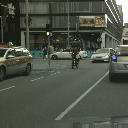

In [ ]:
# Show the chosen image with ground truth bounding boxes visualized.
# index = 8

# img = images[index].copy()

# cv2_imshow(img)

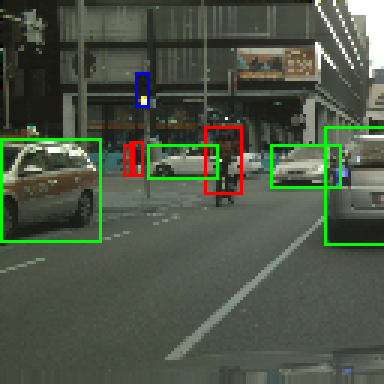

In [ ]:
# class P - red, class T - blue, class C - green  
# c = [(0, 0, 255), (255, 0, 0), (0, 255, 0)] 

# thickness = 1
  
# for k in raw_labels[index]:
#   color = c[int(k[0])]
#   x1,y1,x2,y2 = k[1:5]
#   image = cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), color, thickness)
  
# scale_percent = 300 # percent of original size
# # dim = (w,h)
# dim = (int(image.shape[1] * scale_percent / 100), int(image.shape[0] * scale_percent / 100))
# cv2_imshow(cv2.resize(image, dim, interpolation = cv2.INTER_AREA)) 

Part 1.2

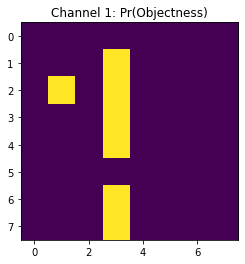

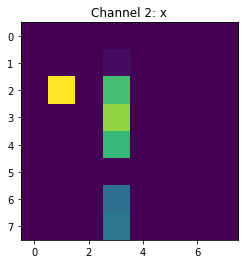

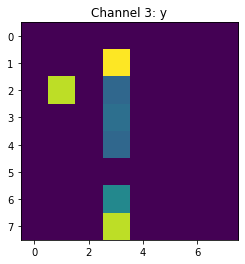

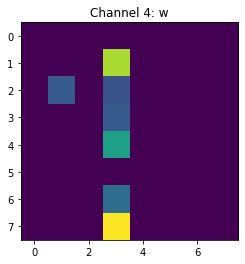

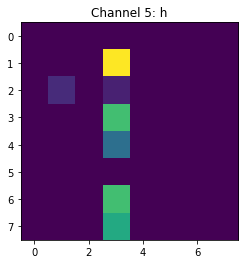

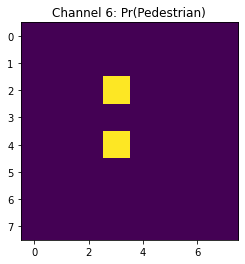

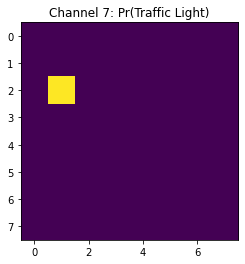

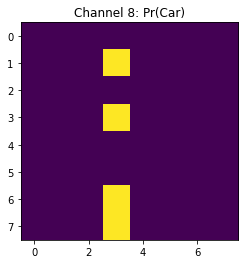

In [ ]:
# Visualize the 8x8x8 representation.
# channel_label = ["Channel 1: Pr(Objectness)","Channel 2: x","Channel 3: y","Channel 4: w",
#                  "Channel 5: h","Channel 6: Pr(Pedestrian)","Channel 7: Pr(Traffic Light)","Channel 8: Pr(Car)"]
# def visualize_channels(channels):
#   for i in range(channels.shape[0]):
#       fig = plt.figure()
#       ax  = fig.add_subplot(111)
#       plt.imshow(channels[i,:,:])
#       plt.title(channel_label[i])
#       plt.show()

# # Visualize for image with index 8
# labels = process_labels(raw_labels[index:index+1])
# visualize_channels(labels[0])

Part 1.3

In [ ]:
# Convert back to the original representation (test cases below should pass).
# reconstruct_raw_labels(labels[0])

array([[  2.,   0.,  46.,  33.,  80.],
       [  1.,  45.,  24.,  49.,  35.],
       [  0.,  41.,  48.,  44.,  58.],
       [  2.,  49.,  48.,  72.,  59.],
       [  0.,  68.,  42.,  80.,  64.],
       [  2.,  90.,  48., 113.,  62.],
       [  2., 108.,  42., 128.,  81.]])

In [ ]:
# Original Raw_label
# raw_labels[index:index+1][0]

array([[  2.,  90.,  48., 113.,  62.],
       [  2.,   0.,  46.,  33.,  80.],
       [  2., 108.,  42., 128.,  81.],
       [  0.,  68.,  42.,  80.,  64.],
       [  1.,  45.,  24.,  49.,  35.],
       [  0.,  43.,  47.,  47.,  58.],
       [  0.,  41.,  48.,  44.,  58.],
       [  2.,  49.,  48.,  72.,  59.]])

##Data Setup

In [ ]:
# labels = process_labels(raw_labels)
# labels.shape

torch.Size([9900, 8, 8, 8])

In [ ]:
# Data Setup
import torchvision
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
          x = self.transform(x)

        return x, y
    
    def __len__(self):
        return len(self.data)

# batch_size = 32

# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(), 
#     torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
# ])

# # Loaders
# train_loader = torch.utils.data.DataLoader(ImageDataset(images[:9000], labels[:9000],transform=transform),
#                             batch_size=batch_size,shuffle=False)

# test_loader = torch.utils.data.DataLoader(ImageDataset(images[9000:], labels[9000:],transform=transform),
#                             batch_size=batch_size,shuffle=True)

In [ ]:
# next(iter(train_loader))[0].shape

torch.Size([32, 3, 128, 128])

In [ ]:
# next(iter(train_loader))[1].shape

torch.Size([32, 8, 8, 8])

2. Implement the loss function. (3%)

In [ ]:
# Function implemented above 
# target = labels[0].unsqueeze(0)
# output = torch.where(target>0,target+0.005,0)
# loss, localisation_loss , confidence_loss , class_loss = yolo_loss(target,output)
# print(f"Total Loss\t\t: {loss.item():.2f} \nLocalisation loss\t: {localisation_loss.item():.2f} \nBox confidence score\t: {confidence_loss.item():.2f} \nPrediction class loss\t: {class_loss.item():.2f}")

Total Loss		: 0.17 
Localisation loss	: 0.01 
Box confidence score	: 0.16 
Prediction class loss	: 0.00


3. Make block diagram of requested architecture. Label the diagram with the parts of your code which implement each component. Explain any deviations you made from the described architecture. (15%)

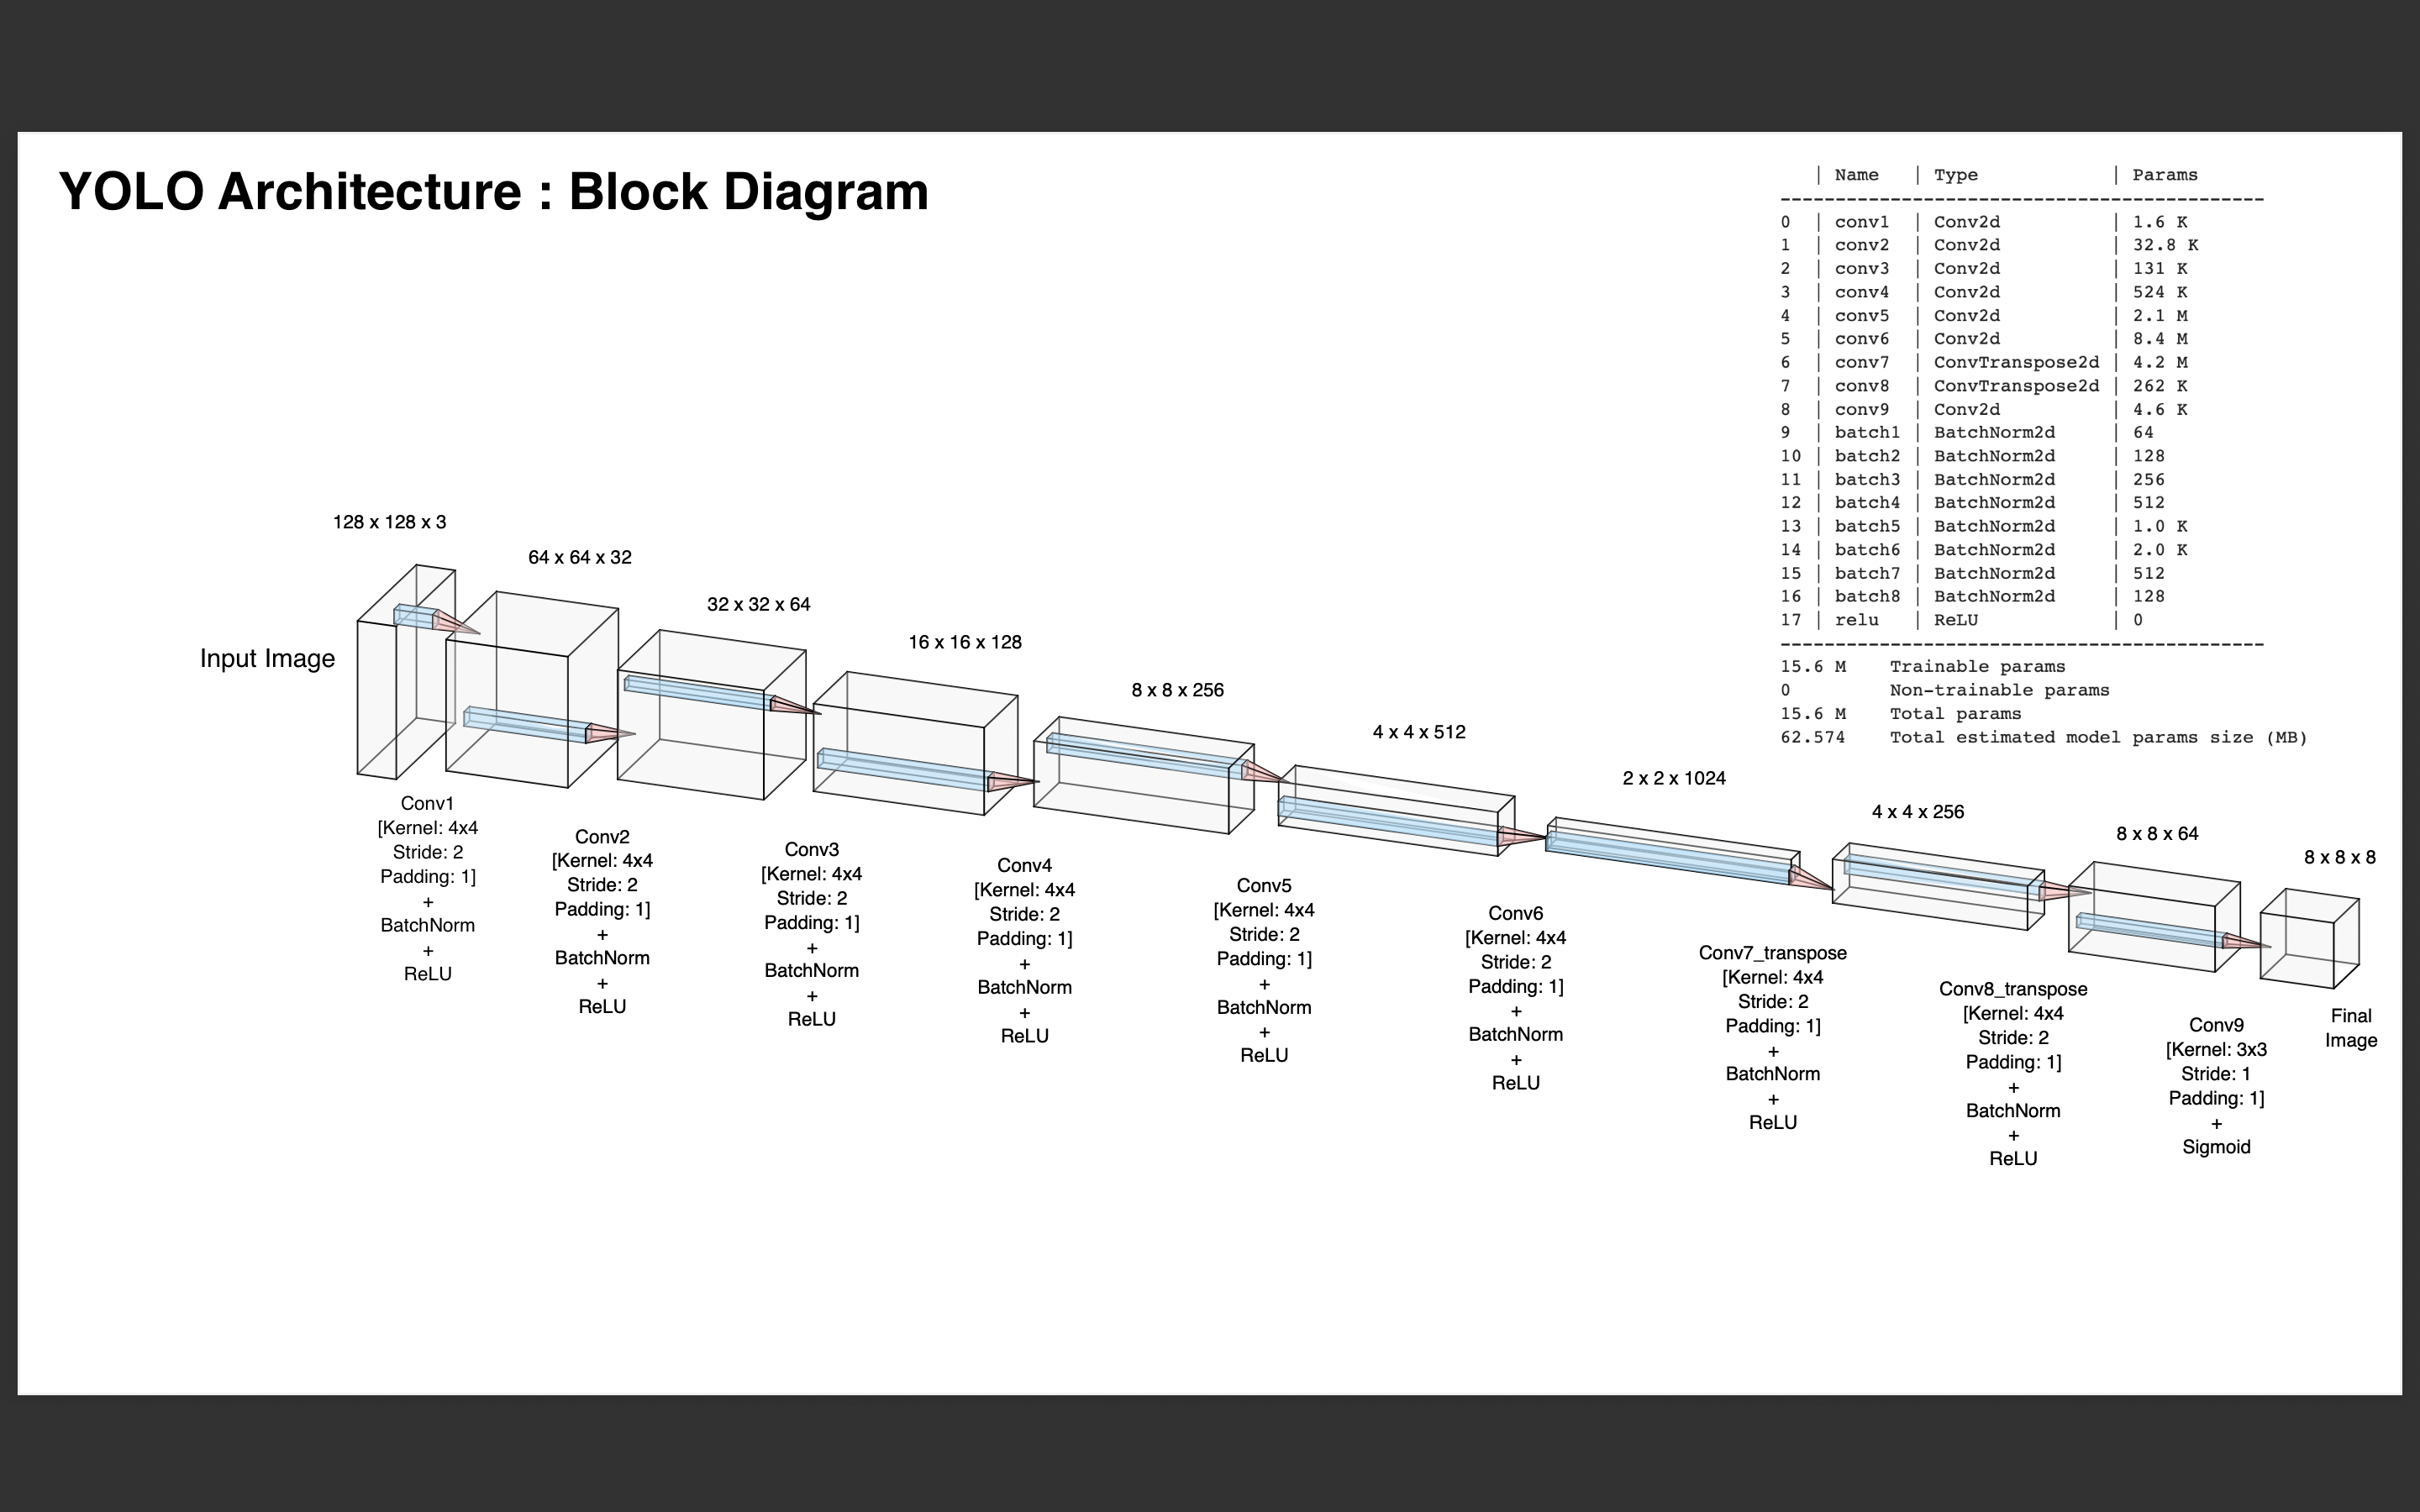

In [ ]:
# from IPython.display import Image
# Image('/content/Diagram.png')

### Description 

- Our yolo architecture has 7 convolution layers and 2 convolution-transpose layers. 

- Except for the last, all other layers have been followed up with ReLU and BatchNorm Layers. While BatchNorm here helps to accelerate the training and prevent exploding values by normalizing the output from previous layers, ReLU is used as an activation function to help the model capture complex image attributes by introducing non linearity. 

- The final layer is followed by sigmoid layer so that the final output is does not have exploded values for loss and we have easier values to work with as the probability scores are needed in the inference and training stages of our modeling. Adding the sigmoid layer at the end is the only deviation we took from the original architecture given in the project. 

- Our input image was 128x128x3 and the final output image is 8x8x8

In [ ]:
# model = YOLO().to(device)
# model

YOLO(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv7): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv8): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv9): Conv2d(64, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

4. Show a plot of the loss over training for your model. (Raw Tensorboard output is not sufficient) (10%) 

In [ ]:
## Setup your training
# checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor="val_loss",
#                                                    save_top_k=-1,
#                                                    dirpath='/content/drive/MyDrive/yolo_maybe/',
#                                                    filename='yolo-epoch{epoch:02d}-loss{val_loss:.2f}'
#                                                    )
# tb_logger = pl_loggers.TensorBoardLogger("/content/drive/MyDrive/yolo_maybe/log")

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=log/

In [ ]:
## Train your model
# trainer = pl.Trainer(gpus=1, logger=tb_logger, max_epochs=40, callbacks=[checkpoint_callback])
# trainer.fit(model, train_loader, test_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /content/drive/.shortcut-targets-by-id/1N9_-eusKqLDCKPnEHILHs0uuokGVuYyr/yolo_maybe exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of c

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


In [ ]:
# train_results

In [ ]:
# trainer.save_checkpoint("/content/drive/MyDrive/yolo_CIS680/model_final.ckpt")

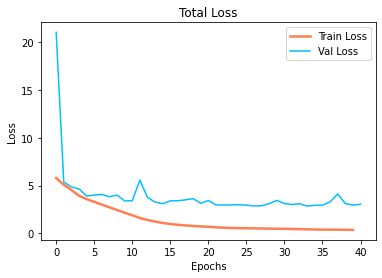

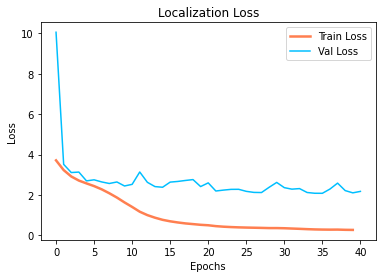

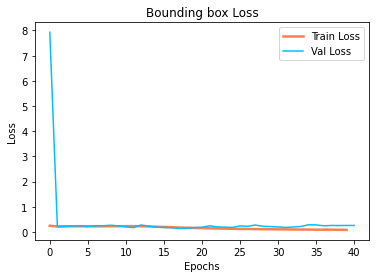

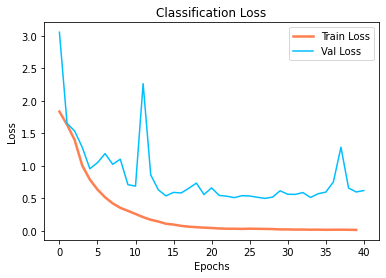

In [ ]:
# Plot the results
loss = ['Total Loss','Localization Loss','Bounding box Loss','Classification Loss']
for i in range(len(train_loss_list)):
  plt.plot(train_loss_list[list(train_loss_list.keys())[i]],linewidth=2.5,color='coral',label='Train Loss')
  plt.plot(val_loss_list[list(train_loss_list.keys())[i]],linewidth=1.5,color='deepskyblue',label='Test Loss')
  plt.legend(['Train Loss','Val Loss'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(loss[i])
  plt.show()

Extra Predictions 

In [ ]:
# def reconstruct_raw_labels(labels, img_dim=128):
#     i, j = torch.where(labels[0]>0)
#     raw_labels = []
#     for p in range(len(i)):
#       c = np.argmax(labels[5:],axis=0)[i[p]][j[p]]
#       x,y,w,h = labels[1][i[p]][j[p]],labels[2][i[p]][j[p]],labels[3][i[p]][j[p]],labels[4][i[p]][j[p]]
#       x1,y1,x2,y2 = get_cord(x,y,w,h,i[p],j[p])

#       raw_labels.append([c, x1.item(),y1.item(),x2.item(),y2.item()])
#     return np.array(raw_labels)

In [ ]:
def plot_bbox(y_hat,img=[]):
  # class P - red, class T - blue, class C - green  
  c = [(0, 0, 255), (255, 0, 0), (0, 255, 0)] 

  if img==[]:
    img = np.ones((128,128,3))

  thickness = 1
    
  for k in reconstruct_raw_labels(y_hat):
    color = c[int(k[0])]
    x1,y1,x2,y2 = k[1:5]
    image = cv2.rectangle(img, (int(np.round(x1)),int(np.round(y1))), (int(np.round(x2)),int(np.round(y2))), color, thickness)
    
  scale_percent = 300 # percent of original size
  # dim = (w,h)
  dim = (int(image.shape[1] * scale_percent / 100), int(image.shape[0] * scale_percent / 100))
  cv2_imshow(cv2.resize(image, dim, interpolation = cv2.INTER_AREA)) 
  # cv2_imshow(image)

#Part 2

5. Show a plot of the mean Average Precision over training for your model. (10%)

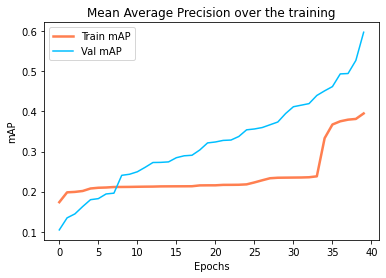

In [ ]:
plt.plot(train_results,linewidth=2.5,color='coral',label='Train mAP')
plt.plot(val_results,linewidth=1.5,color='deepskyblue',label='Test mAP')
plt.legend(['Train mAP','Val mAP'])
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.title('Mean Average Precision over the training')
plt.show()

6. For one image in the inference step, show the predicted bounding boxes in the image before performing any elimination. Then, show the annotated image after the low probability bounding boxes are removed. Finally, show image after performing non-max suppression. Label each of these visualizations. See Figure 4 as an example of what this visualization should look like. (15%)

#### Original Image prediction (Image 1)

All original Bounding Boxes


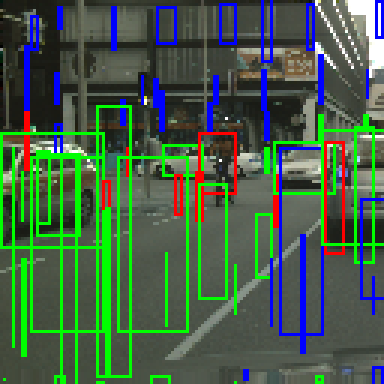

In [ ]:
index = 8
img = images[index].copy()
print("All original Bounding Boxes")
plot_bbox(y_hat[index],img)

#### Image prediction after Low Confidence supression (Image 1)

Bounding Boxes after low confidence supression


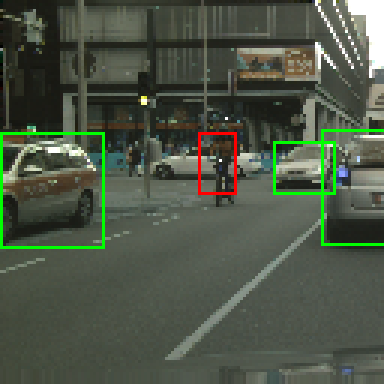

In [ ]:
img = images[index].copy()
supressed = low_confidence_suppression(y_hat[index])
print("Bounding Boxes after low confidence supression")
plot_bbox(supressed,img)

#### Image after Non - Max supression (Image 1)

Bounding Boxes after Non Max supression


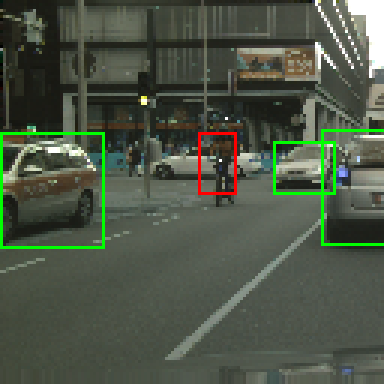

In [ ]:
# non max supression 
nms = non_max_suppression(supressed)
print("Bounding Boxes after Non Max supression")
plot_bbox(nms,img)

7. For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)

All original Bounding Boxes


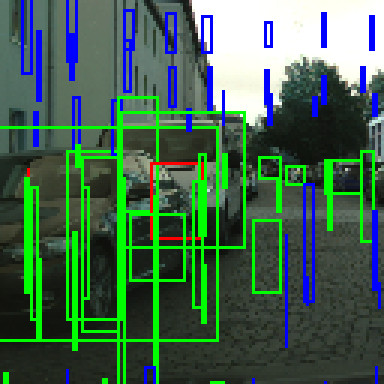

Bounding Boxes after low confidence supression


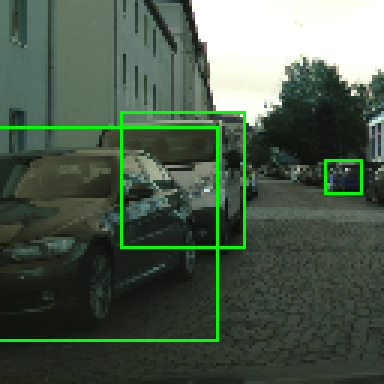

Bounding Boxes after Non Max supression


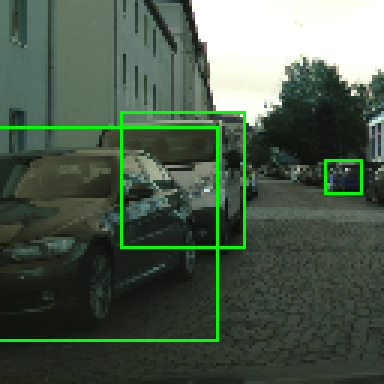

In [ ]:
index = 3
img = images[index].copy()
print("All original Bounding Boxes")
plot_bbox(y_hat[index],img)

# low confidence supression 
img = images[index].copy()
supressed = low_confidence_suppression(y_hat[index])
print("Bounding Boxes after low confidence supression")
plot_bbox(supressed,img)

# non max supression 
nms = non_max_suppression(supressed)
print("Bounding Boxes after Non Max supression")
plot_bbox(nms,img)

All original Bounding Boxes


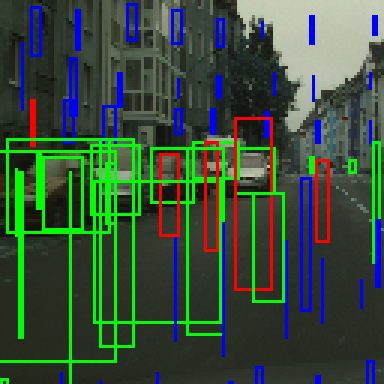

Bounding Boxes after low confidence supression


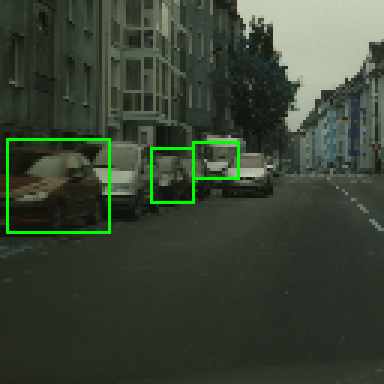

Bounding Boxes after Non Max supression


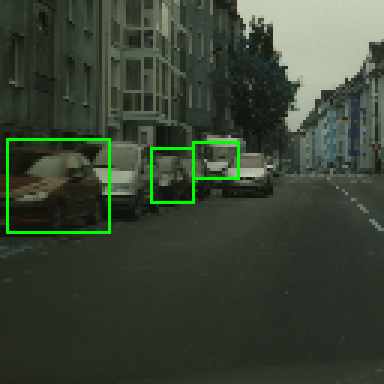

In [ ]:
index = 12
img = images[index].copy()
print("All original Bounding Boxes")
plot_bbox(y_hat[index],img)

# low confidence supression 
img = images[index].copy()
supressed = low_confidence_suppression(y_hat[index])
print("Bounding Boxes after low confidence supression")
plot_bbox(supressed,img)

# non max supression 
nms = non_max_suppression(supressed)
print("Bounding Boxes after Non Max supression")
plot_bbox(nms,img)

Class 0


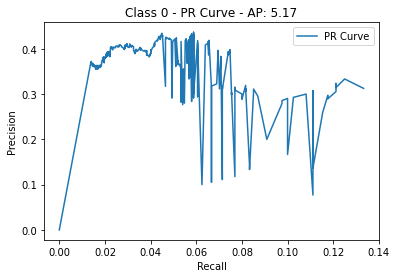

Class 1


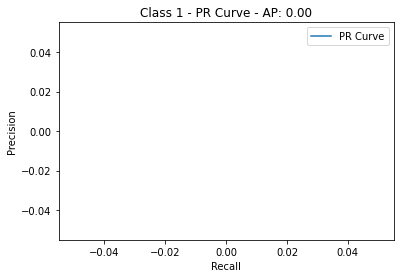

Class 2


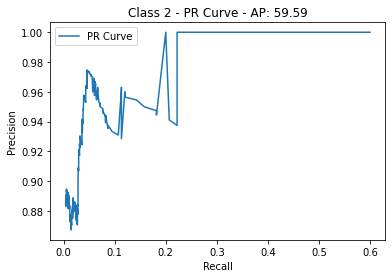

In [ ]:
res = results(y,y_hat)

print("Class 0")
prec = res['pr'][0][0]
rec = res['pr'][0][1]
ind = torch.argsort(rec, descending=False)
plt.plot(rec[ind].cpu(),prec[ind].cpu())
plt.legend(['PR Curve'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Class 0 - PR Curve - AP: {res["ap"][0]*100:.2f}')
plt.show()

print("Class 1")
prec = res['pr'][1][0]
rec = res['pr'][1][1]
ind = torch.argsort(rec, descending=False)
plt.plot(rec[ind].cpu(),prec[ind].cpu())
plt.legend(['PR Curve'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Class 1 - PR Curve - AP: {res["ap"][1]*100:.2f}')
plt.show()

print("Class 2")
prec = res['pr'][2][0]
rec = res['pr'][2][1]
ind = torch.argsort(rec, descending=False)
plt.plot(rec[ind].cpu(),prec[ind].cpu())
plt.legend(['PR Curve'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Class 2 - PR Curve - AP: {res["ap"][2]*100:.2f}')
plt.show()

In [ ]:
res['mean_ap']

0.21588790913422903

**The Mean Average Precison for inference stage: 21.59**

8. Explain any issues or challenges you had with your implementation. Explain the performance you achieved and any interesting observations you made while training your network. Discuss hypotheses for how you could improve the performance of your implementation further. (20%)

Architecture details:

LR: 10e-3

Optimizer: Adam

LRScheduler: Exponential LR


Issues and Challenges:
1. The architecture didn’t have an activation function so we had to introduce the sigmoid function before the final output from the image. Here we tried couple of other activation functions and settled on sigmoid as it made the most sense with this use-case.

2. After the inference of our model we realized that our bounding boxes was very narrow. This led us to understand that we were making some mistakes in the training loss calculation. This debugging took quite some time as the loss was at an acceptable rate but it needed significant improvement so that we could get appropriate bounding boxes(and not thin).

3. The loss was center of our issues and challenges in this project. Given the complex nature of its query we had a lot of moving parts to take care of. For instance, the confidence score was an easy formula however, the IOU needed to calculate it took quite a lot of time. The major time consumption was to make sure the grid points are made in reference to the entire grid cell and correctly detect the corresponding bounding boxes.

4. Our model was overfitting by quite a large amount. Our loss function converged initially but ultimately diverged by a huge amount. This is when we decided to introduce the lrScheduler which within itself turned out to be an extremely complex problem. First a lot of thought and trials went to getting the right scheduler and then the choosing the right parameters for it too was quite a hassle. By doing this we are ultimately able to decrease our loss from around 5 to 0.2-0.3

5. During the low-suppression itself we ended up removing large number of bounding boxes so the non-max suppression wasn’t used much. We tested this for several images from different classes.


6. The inference part turned out to be quite an eye-opener as it pointed out to yet another issue. During our analysis we observed that the Pr(object) was quite low and thus pointing out the root cause behind our bad precision-recall rates. 

7. During the first week of the project we were under the impression that the epochs we used were enough as the loss was steadily decreasing and the overfitting also didn’t seem like an issue. But during the inference stage we realized there quite a few underlying issues that had not been considered. The first towards solving this was increasing the epoch to 40 which quite often led to colab running out of GPU limits and huge calculation time. 

8. While we have discussed how various errors were realized after seeing our recall, precision, average precision and MAP values, calculating these was also not an easy task. Understanding how to calculate these metrics for object detection turned quite tricky. Good coding practice such as vectorization instead of various for loops, removing unnecessary  list and optimizing algorithm was needed so that our training function did not take too much time for each epoch.

9. Apart from time consuming understanding of how to calculate these metrics we also faced issues when it came calculating the recall. Since the IOUs were just for single images and later precision for the entire class, quite a few parameters had to be tracked and sent. Recall calculation in particular required us to rewrite our function couple of extra times.



Improvements:

1. Having more anchor boxes would increase the complexity of the problem but it would also lead too better detection and getting high confidence bounding boxes.

2. Getting better resolution of images would help in better detection as the noise from these images diverged the results time and again despite using several suppression functions to remove the extra boxes made via them

3. We observed that we were getting really good predictions for cars while not so much for the pedestrians and even worse for the lights. A suggestion would be to give more images for the latter 2 classes and also making sure the images that have these classes have high quality. Croping and transformation to view these classes involved dealing with blurred and noisy image

4. We would also wanted to run our code for even higher number of epochs and not spend too much time on hand engineering the features which we believe would be possible by making use of large number of images, introducing data augmentation and using transfer learning or stronger models

## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output. 

For part (a), your submission should consist of this file and a pdf report. This report can simply be a pdf version of this document. Example conversion code below.

**Please save before exporting!**

In [ ]:
!sudo apt-get update &> /dev/null
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended &> /dev/null
!jupyter nbconvert --to pdf cis680hw2.ipynb